In [11]:
%pip install --quiet "evadb[vision,notebook]"
%pip install --quiet facenet_pytorch
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# A video of a happy person
# !wget -nc "https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1" -O defhappy.mp4

# Adding Emotion detection
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/emotion_detector.py

# Adding Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/face_detector.py

File ‘emotion_detector.py’ already there; not retrieving.

File ‘face_detector.py’ already there; not retrieving.



In [13]:
cursor.query("DROP TABLE IF EXISTS HAPPY;").df()
cursor.query("LOAD VIDEO 'Actor_01/01-02-06-02-01-01-01.mp4' INTO HAPPY").df()

,0
0,Number of loaded VIDEO: 1


In [14]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS EmotionDetector 
    INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
    OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
    TYPE  Classification IMPL 'emotion_detector.py';
""").df()

,0
0,"Function EmotionDetector already exists, nothi..."


In [15]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS FaceDetector
    INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
    OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
          scores NDARRAY FLOAT32(ANYDIM))
    TYPE  FaceDetection
    IMPL  'face_detector.py';
""").df()

,0
0,"Function FaceDetector already exists, nothing ..."


In [16]:

cursor.query("SELECT id, FaceDetector(data) FROM HAPPY WHERE id < 10").df()

,happy.id,facedetector.bboxes,facedetector.scores
0,0,"[[518, 113, 821, 561]]",[0.9999929666519165]
1,1,"[[520, 117, 824, 562]]",[0.9999884366989136]
2,2,"[[517, 112, 824, 561]]",[0.9999909400939941]
3,3,"[[519, 115, 825, 562]]",[0.9999915361404419]
4,4,"[[516, 114, 825, 564]]",[0.9999903440475464]
5,5,"[[520, 123, 822, 565]]",[0.999984622001648]
6,6,"[[509, 120, 815, 565]]",[0.9999876022338867]
7,7,"[[503, 128, 816, 574]]",[0.9999136924743652]
8,8,"[[494, 118, 808, 569]]",[0.9999984502792358]
9,9,"[[492, 126, 803, 573]]",[0.9999877214431763]


In [17]:
query = cursor.query("""
    SELECT id, bbox, EmotionDetector(Crop(data, bbox))
    FROM HAPPY JOIN LATERAL UNNEST(FaceDetector(data)) AS Face(bbox, conf)
    WHERE id < 15
""")
response = query.df()

In [19]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['Face.bbox', 'emotiondetector.labels', 'emotiondetector.scores']][df.index == frame_id]
        if df.size:
            
            x1, y1, x2, y2 = df['Face.bbox'].values[0]
            label = df['emotiondetector.labels'].values[0]
            score = df['emotiondetector.scores'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # object score
            cv2.putText(frame, str(round(score, 5)), (x1+120, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
        
            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()


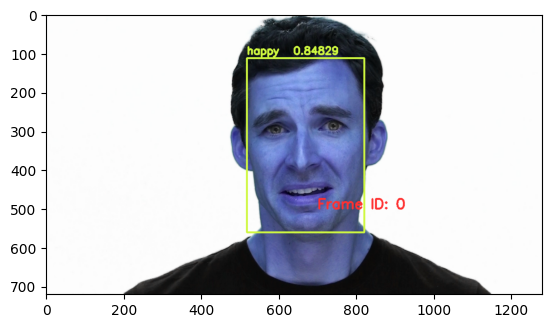

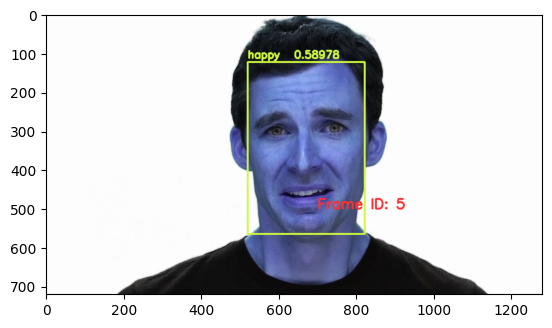

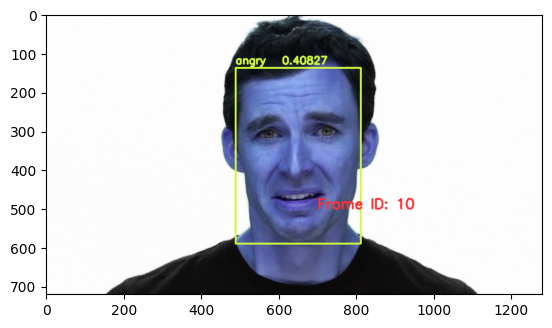

In [20]:
from ipywidgets import Video, Image
input_path = 'Actor_01/01-02-06-02-01-01-01.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)